First, you can use the 'data/DNA Shapes.ipynb' to use the DNAShapeR to extract the DNA shape characteristics to get the CSV files necessary for this notebook. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Preprocessing #

In [2]:
def parse_fasta(file_name, label):
    sequences = []
    with open(file_name, 'r') as file:
        for line in file:
            if not line.startswith('>'):
                sequences.append((line.strip()))
    return pd.DataFrame({'sequence': sequences, 'label':label})

def one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C':[0,1,0,0], 'G':[0,0,1,0], 'T': [0,0,0,1]}
    return np.array([mapping[nucleotide] for nucleotide in seq])

def read_shape(tf_name, shape_type):
    
    def is_float(string):
        try:
            float(string)
            return True
        except ValueError:
            return False
            
    values_array = []
    labels = ['bound', 'unbound']
    for label in labels:
        with open(tf_name + f"_{label}_" + shape_type + ".csv", 'r') as file:
            file.readline()
            for line in file:
                row_values = [float(value) for value in line.split(",") if is_float(value)]
                values_array.append(row_values)
                row_values = []    
    values_array = np.array(values_array)

    min_vals = values_array.min(axis=0)
    max_vals = values_array.max(axis=0)
    normalized_values = (values_array - min_vals) / (max_vals - min_vals)
    return normalized_values

def format_row(row):
    embedded_array = row[0].flatten()
    row_shapes = row[1:]
    formatted_row = np.concatenate((embedded_array, row_shapes))
    return formatted_row
    
tfs = ['ctcf', 'max']
for tf in tfs:
    bound_data = parse_fasta(f'{tf}_bound.fasta', 1)
    unbound_data = parse_fasta(f'{tf}_unbound.fasta', 0)
    all_data = pd.concat([bound_data, unbound_data], ignore_index=True)
    all_data['1mer'] = all_data['sequence'].apply(one_hot_encode)
    tf_mgw = read_shape(tf, 'MGW')
    tf_prot = read_shape(tf, 'ProT')
    tf_roll = read_shape(tf, 'Roll')
    tf_helt = read_shape(tf, 'HelT')
    tf_ep = read_shape(tf, 'EP')
    tf_1mer = np.array(all_data['1mer']).reshape(-1,1)
    tf_1mer_shape = np.hstack((tf_1mer, tf_mgw, tf_prot, tf_roll, tf_helt, tf_ep))
    all_data['1mer+shape'] = [x.flatten() for x in tf_1mer_shape]
    all_data['1mer+shape'] = all_data['1mer+shape'].apply(lambda x: format_row(x))
    if tf == 'ctcf':
        ctcf_data = all_data
    if tf == 'max':
        max_data = all_data

X_ctcf_1mer = np.array([x.flatten() for x in ctcf_data['1mer'].tolist()])
X_ctcf_1mer_shape = np.array([x.flatten() for x in ctcf_data['1mer+shape'].tolist()])
y_ctcf = ctcf_data['label']
X_ctcf_1mer_train, X_ctcf_1mer_test, y_ctcf_1mer_train, y_ctcf_1mer_test = train_test_split(X_ctcf_1mer, y_ctcf, test_size=0.2, random_state=42)
X_ctcf_1mer_shape_train, X_ctcf_1mer_shape_test, y_ctcf_1mer_shape_train, y_ctcf_1mer_shape_test = train_test_split(X_ctcf_1mer_shape, y_ctcf, test_size=0.2, random_state=42)

X_max_1mer = np.array([x.flatten() for x in max_data['1mer'].tolist()])
X_max_1mer_shape = np.array([x.flatten() for x in max_data['1mer+shape'].tolist()])
y_max = max_data['label']
X_max_1mer_train, X_max_1mer_test, y_max_1mer_train, y_max_1mer_test = train_test_split(X_max_1mer, y_max, test_size=0.2, random_state=42)
X_max_1mer_shape_train, X_max_1mer_shape_test, y_max_1mer_shape_train, y_max_1mer_shape_test = train_test_split(X_max_1mer_shape, y_max, test_size=0.2, random_state=42)

# Grid Search #

In [3]:
def grid_search(X_train, X_test, y_train, y_test):
    log_reg = LogisticRegression(penalty='l1', solver='liblinear', random_state=50)
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    grid = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc')
    grid.fit(X_train, y_train)
    return grid.best_params_, grid.best_score_

In [4]:
best_param, best_score = grid_search(X_ctcf_1mer_train, X_ctcf_1mer_test, y_ctcf_1mer_train, y_ctcf_1mer_test)
print("CTCF 1mer")
print("Best Parameter:", best_param)
print("Best Score:", best_score)

CTCF 1mer
Best Parameter: {'C': 0.1}
Best Score: 0.9546498177084676


In [5]:
best_param, best_score = grid_search(X_ctcf_1mer_shape_train, X_ctcf_1mer_shape_test, y_ctcf_1mer_shape_train, y_ctcf_1mer_shape_test)
print("CTCF 1mer+shape")
print("Best Parameter:", best_param)
print("Best Score:", best_score)

CTCF 1mer+shape
Best Parameter: {'C': 0.1}
Best Score: 0.9535402406626036


In [6]:
best_param, best_score = grid_search(X_max_1mer_train, X_max_1mer_test, y_max_1mer_train, y_max_1mer_test)
print("MAX 1mer")
print("Best Parameter:", best_param)
print("Best Score:", best_score)

MAX 1mer
Best Parameter: {'C': 0.1}
Best Score: 0.9326297431432453


In [7]:
best_param, best_score = grid_search(X_max_1mer_shape_train, X_max_1mer_shape_test, y_max_1mer_shape_train, y_max_1mer_shape_test)
print("MAX 1mer+shape")
print("Best Parameter:", best_param)
print("Best Score:", best_score)

MAX 1mer+shape
Best Parameter: {'C': 0.1}
Best Score: 0.9326434101138743


# Model Validation #

In [8]:
def evaluate_model(X_train, X_test, y_train, y_test, best_C, plot_title):
    log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, random_state=50)
    log_reg.fit(X_train, y_train)
    y_pred_proba = log_reg.predict_proba(X_test)[:,1]
    fpr, tpr, tresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.rcParams.update({'font.size':55})
    plt.figure(figsize=(30,18))
    plt.plot(fpr, tpr, color='darkorange', lw=6, label=f'ROC Curve (area ={auc_score:.4f})')
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{plot_title} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

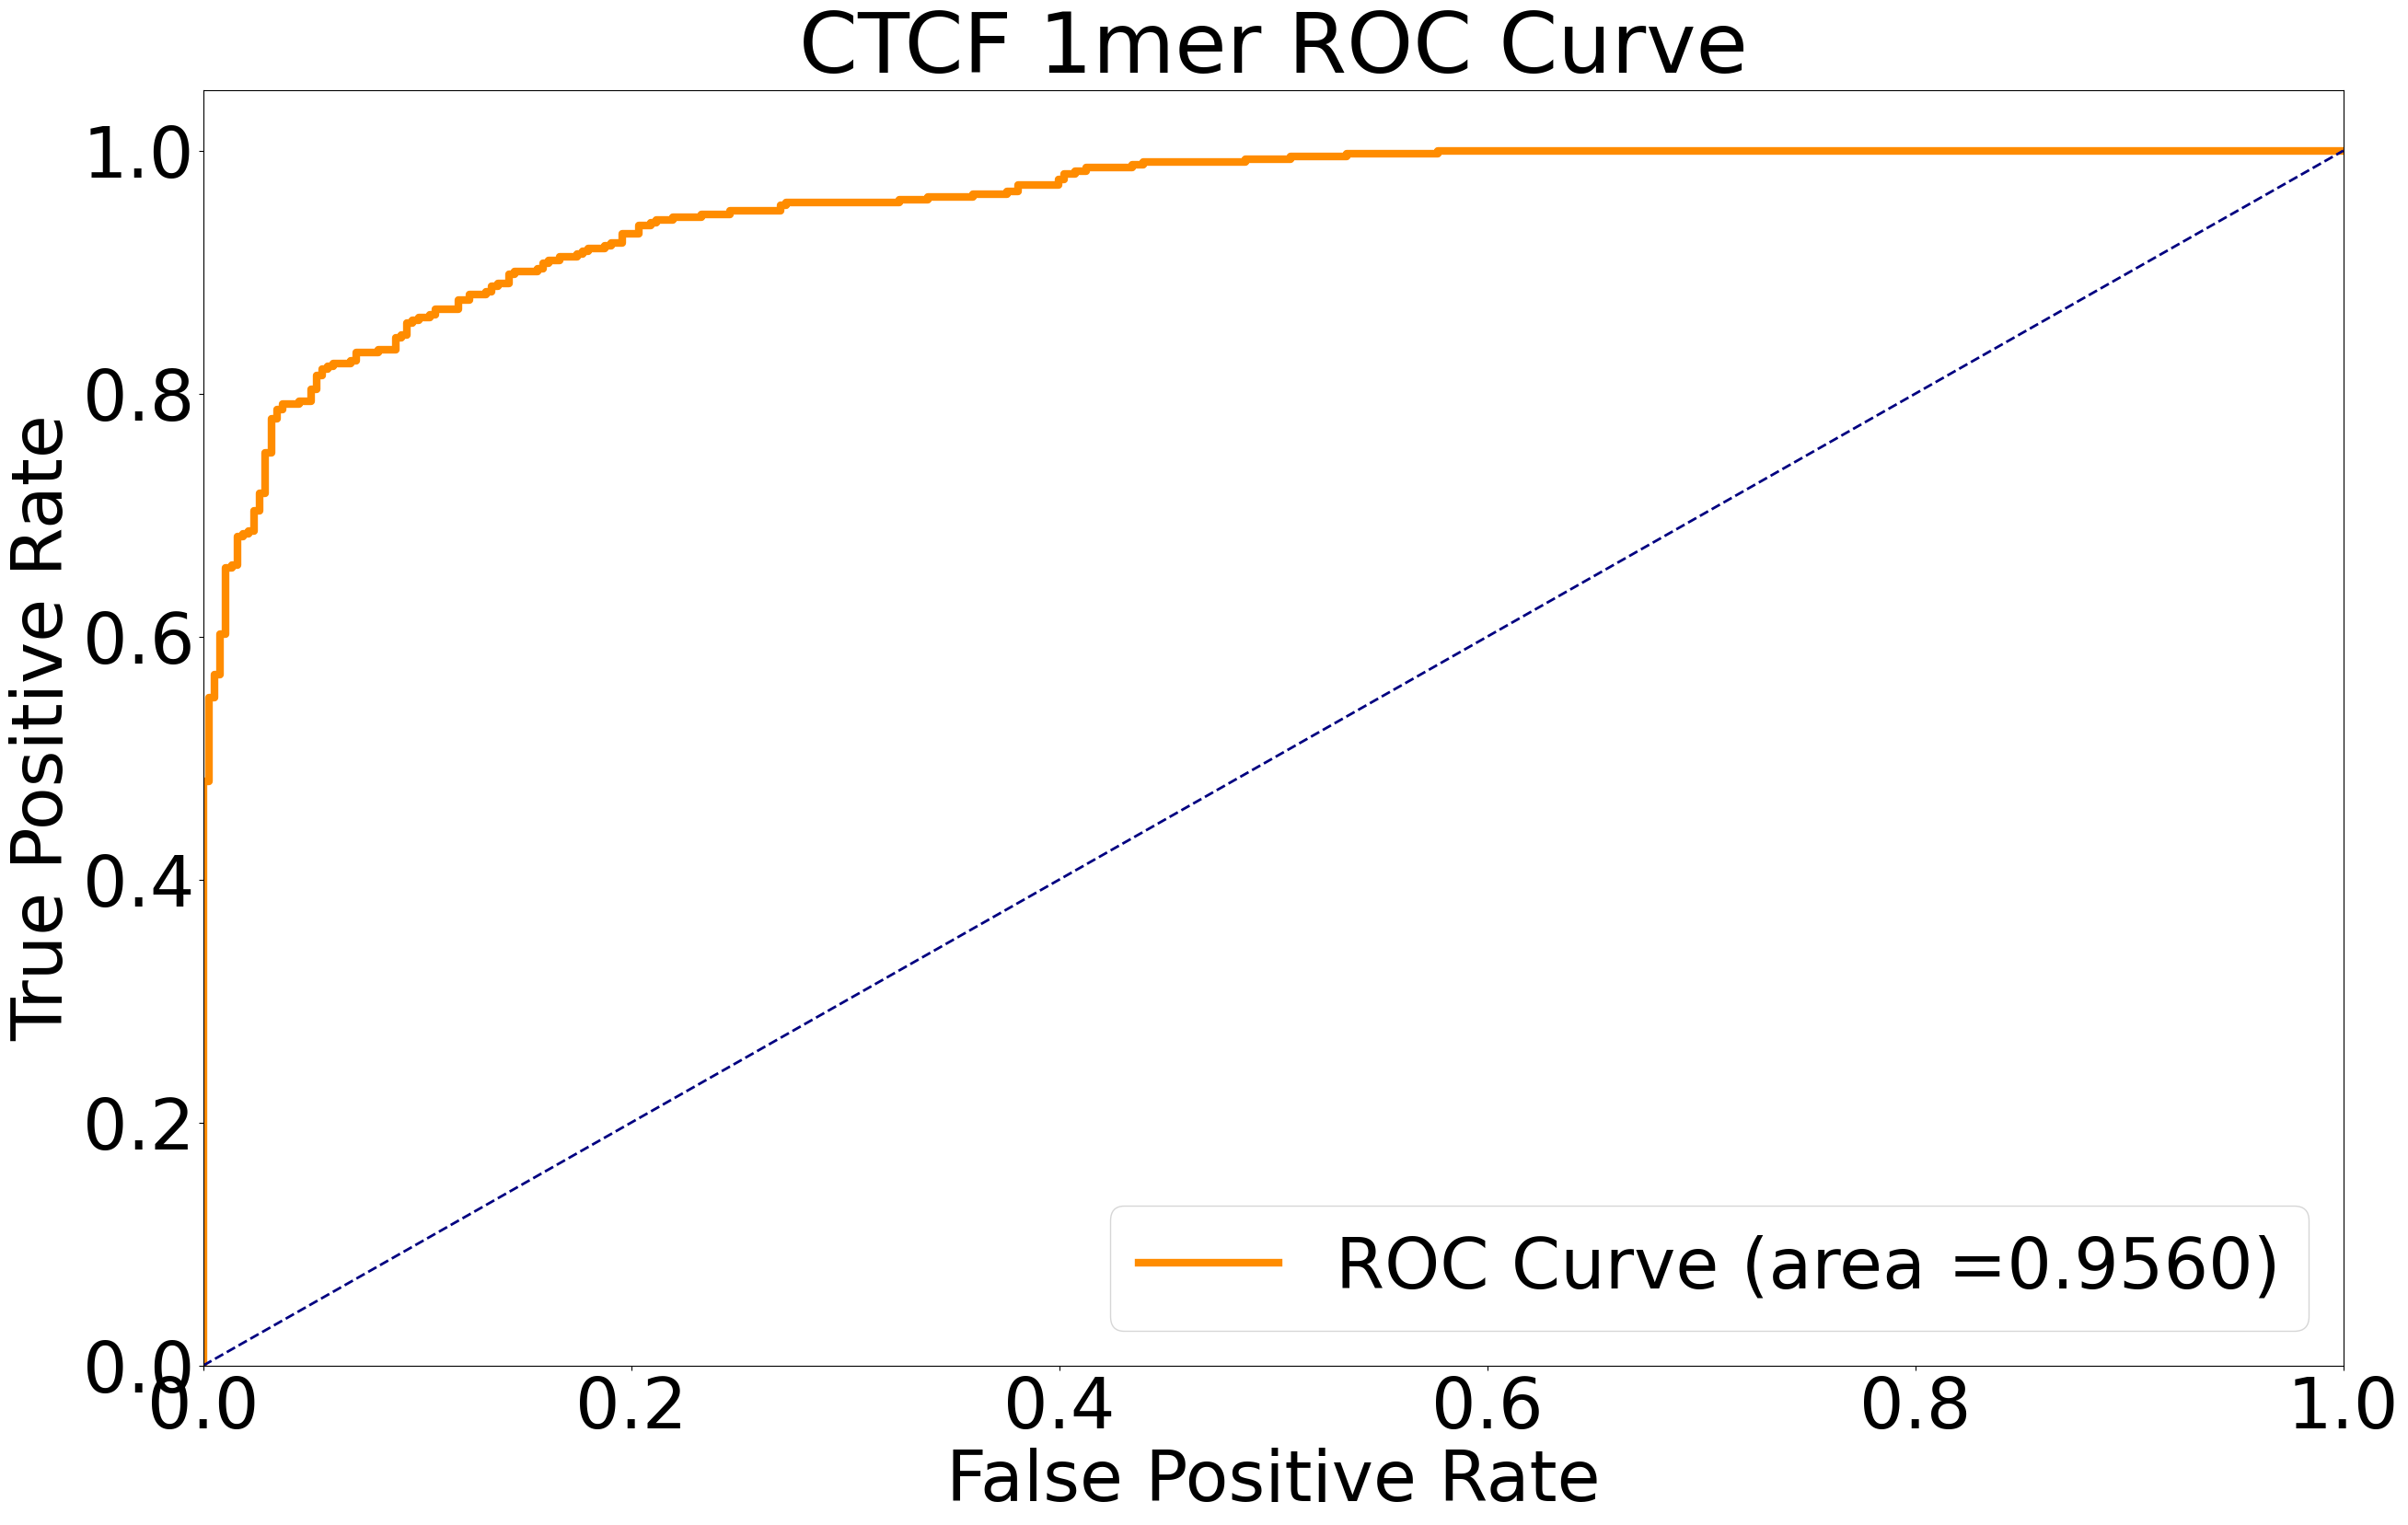

In [9]:
evaluate_model(X_ctcf_1mer_train, X_ctcf_1mer_test, y_ctcf_1mer_train, y_ctcf_1mer_test, 0.1, 'CTCF 1mer')

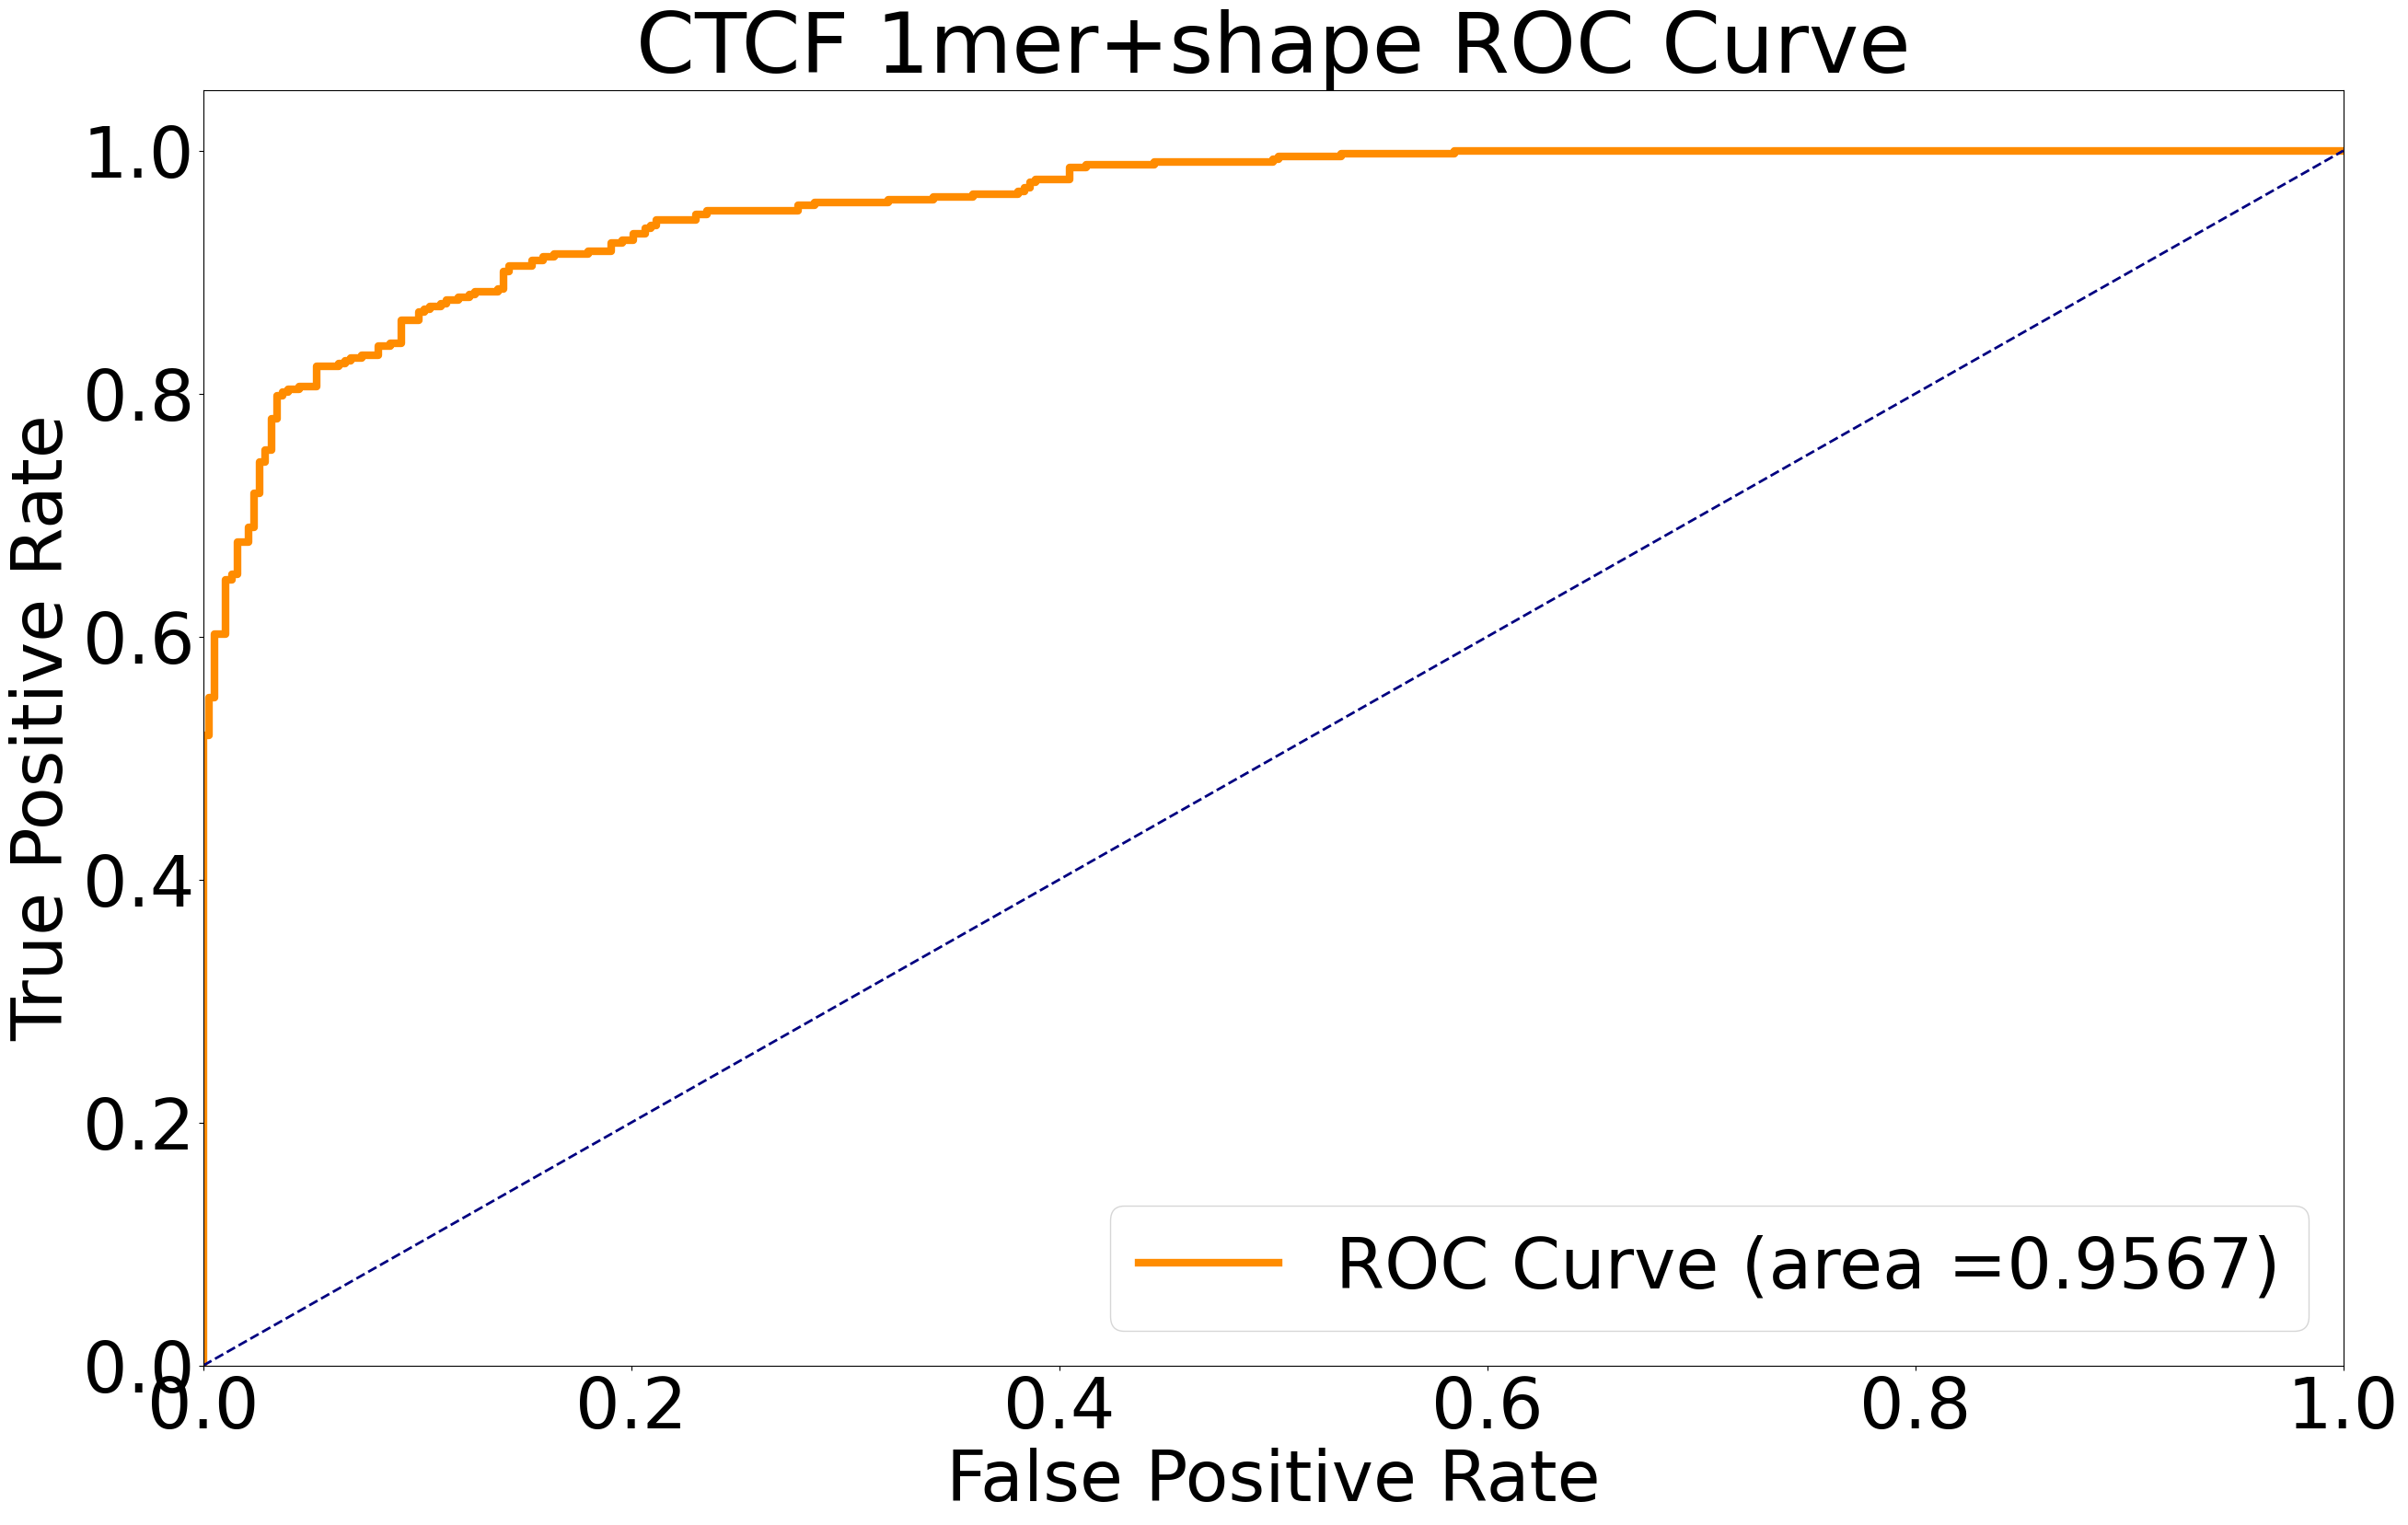

In [10]:
evaluate_model(X_ctcf_1mer_shape_train, X_ctcf_1mer_shape_test, y_ctcf_1mer_shape_train, y_ctcf_1mer_shape_test, 0.1, 'CTCF 1mer+shape')

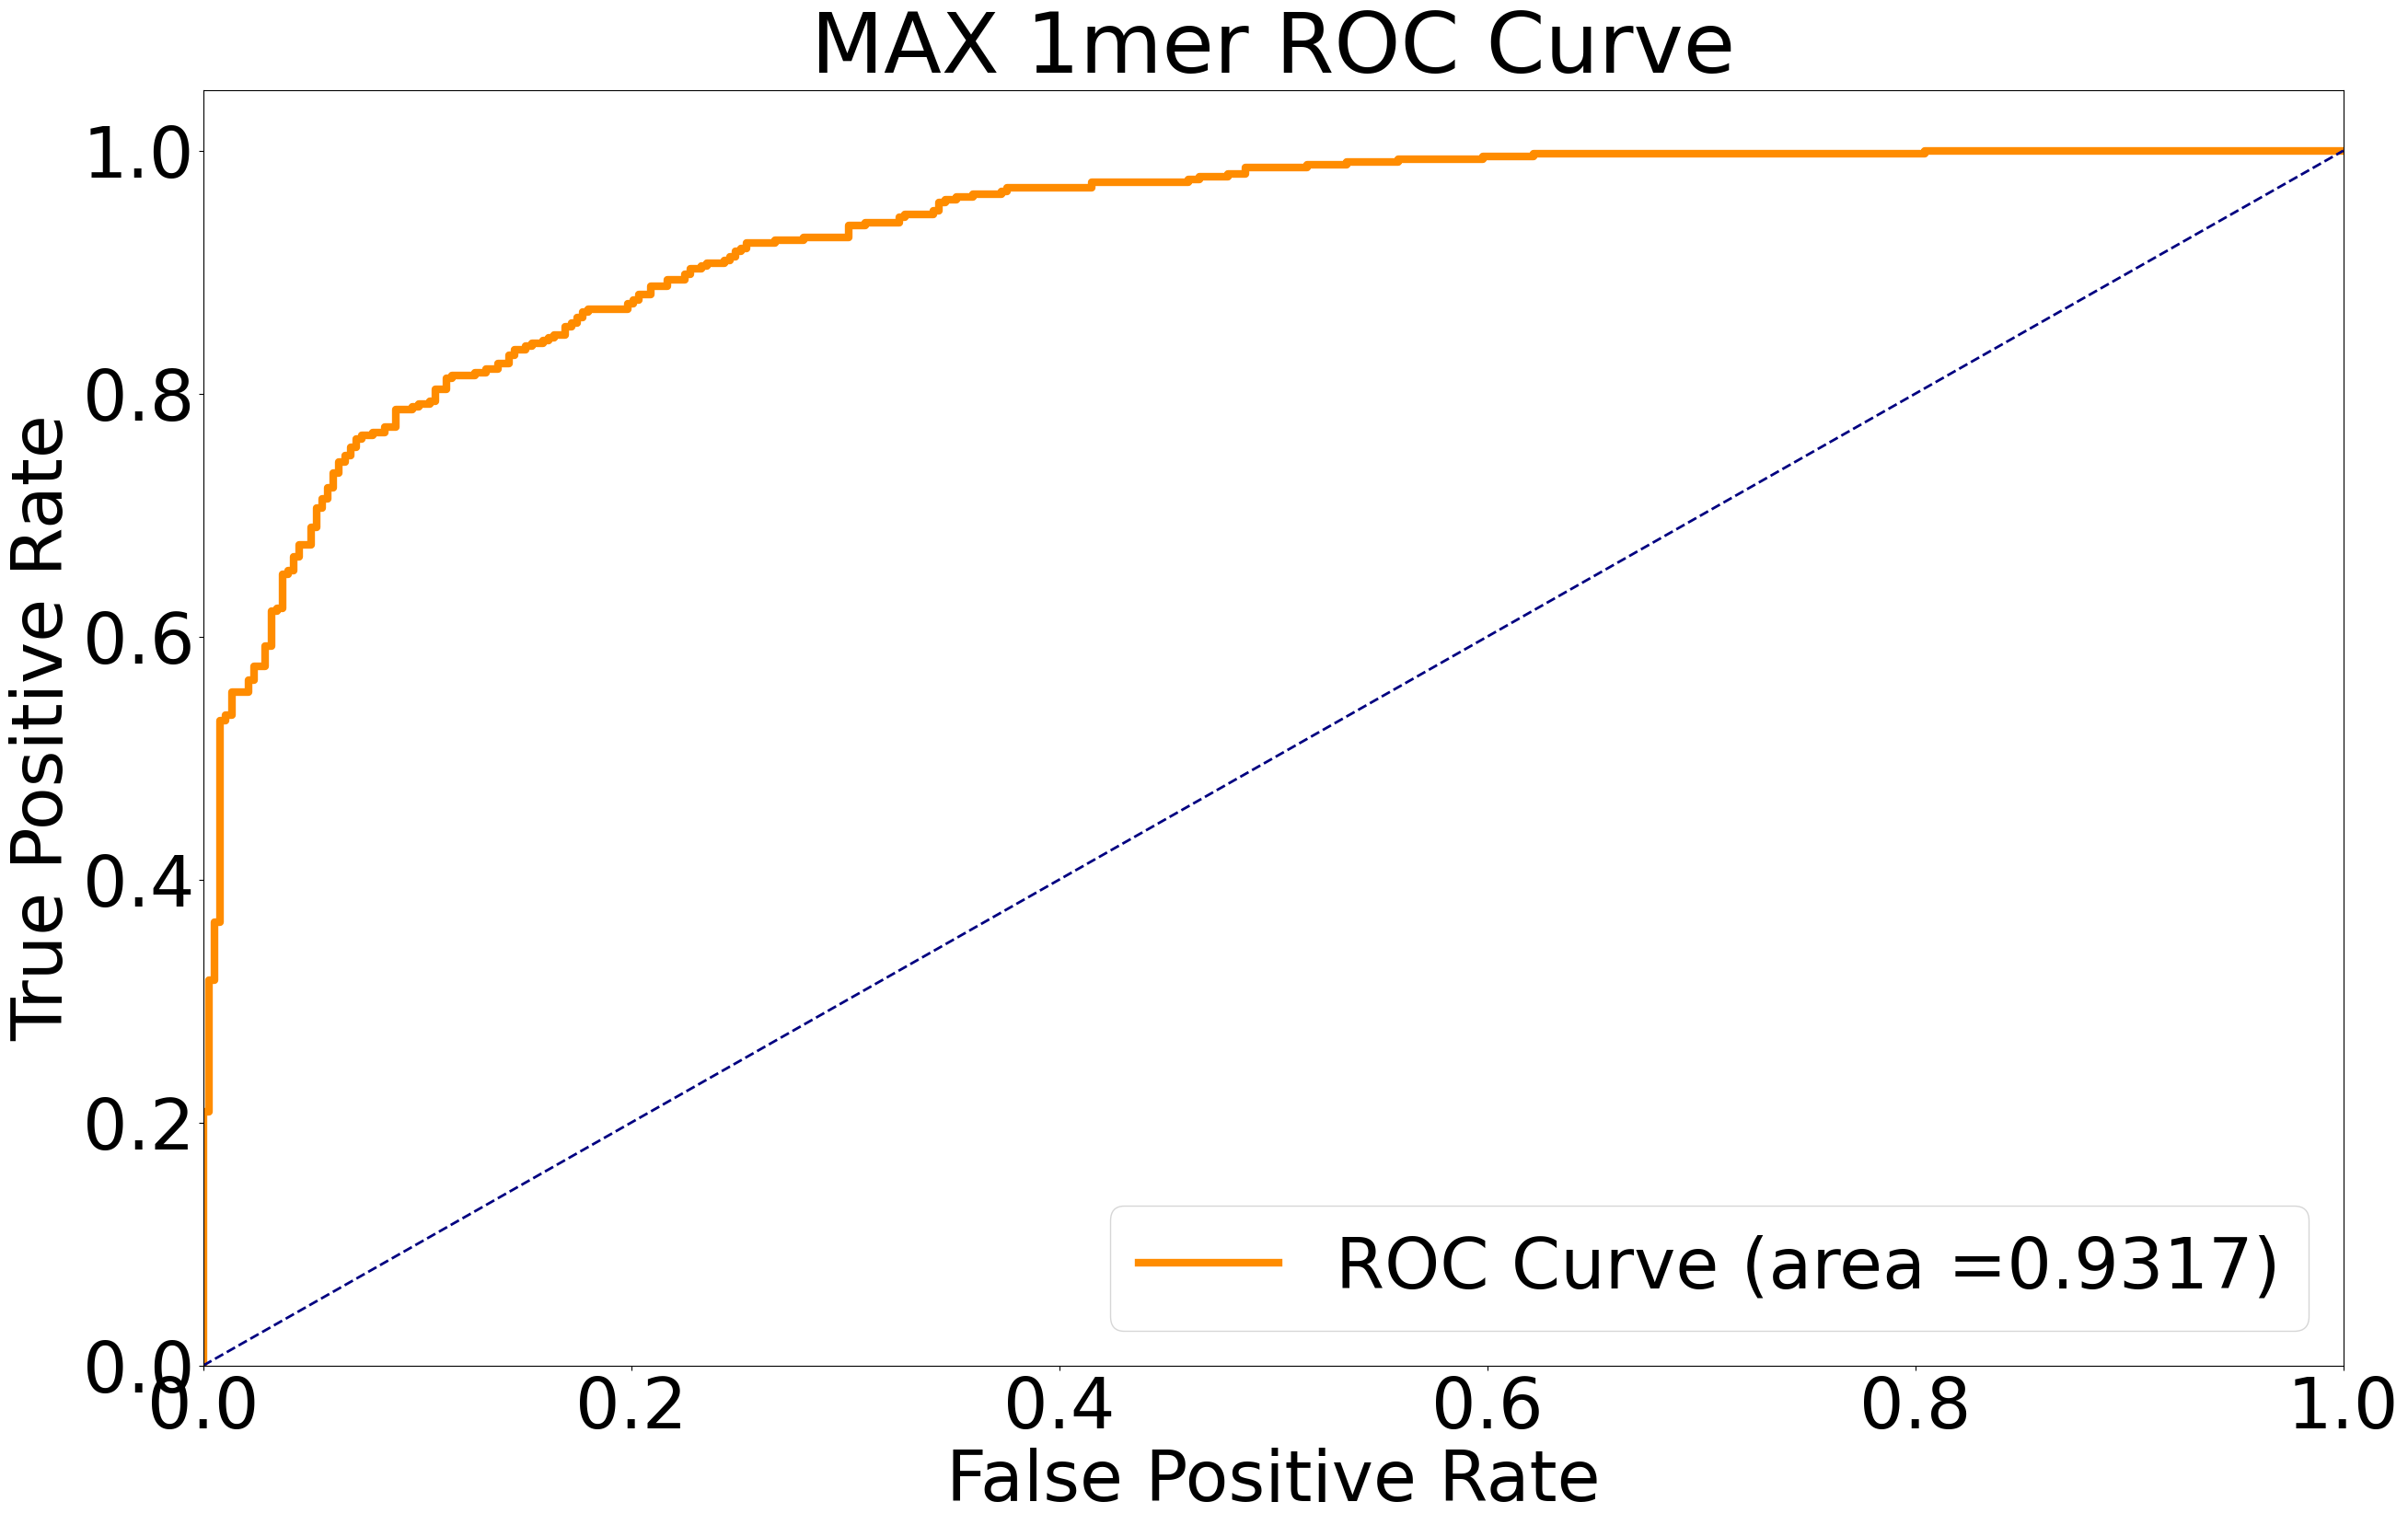

In [11]:
evaluate_model(X_max_1mer_train, X_max_1mer_test, y_max_1mer_train, y_max_1mer_test, 0.1, 'MAX 1mer')

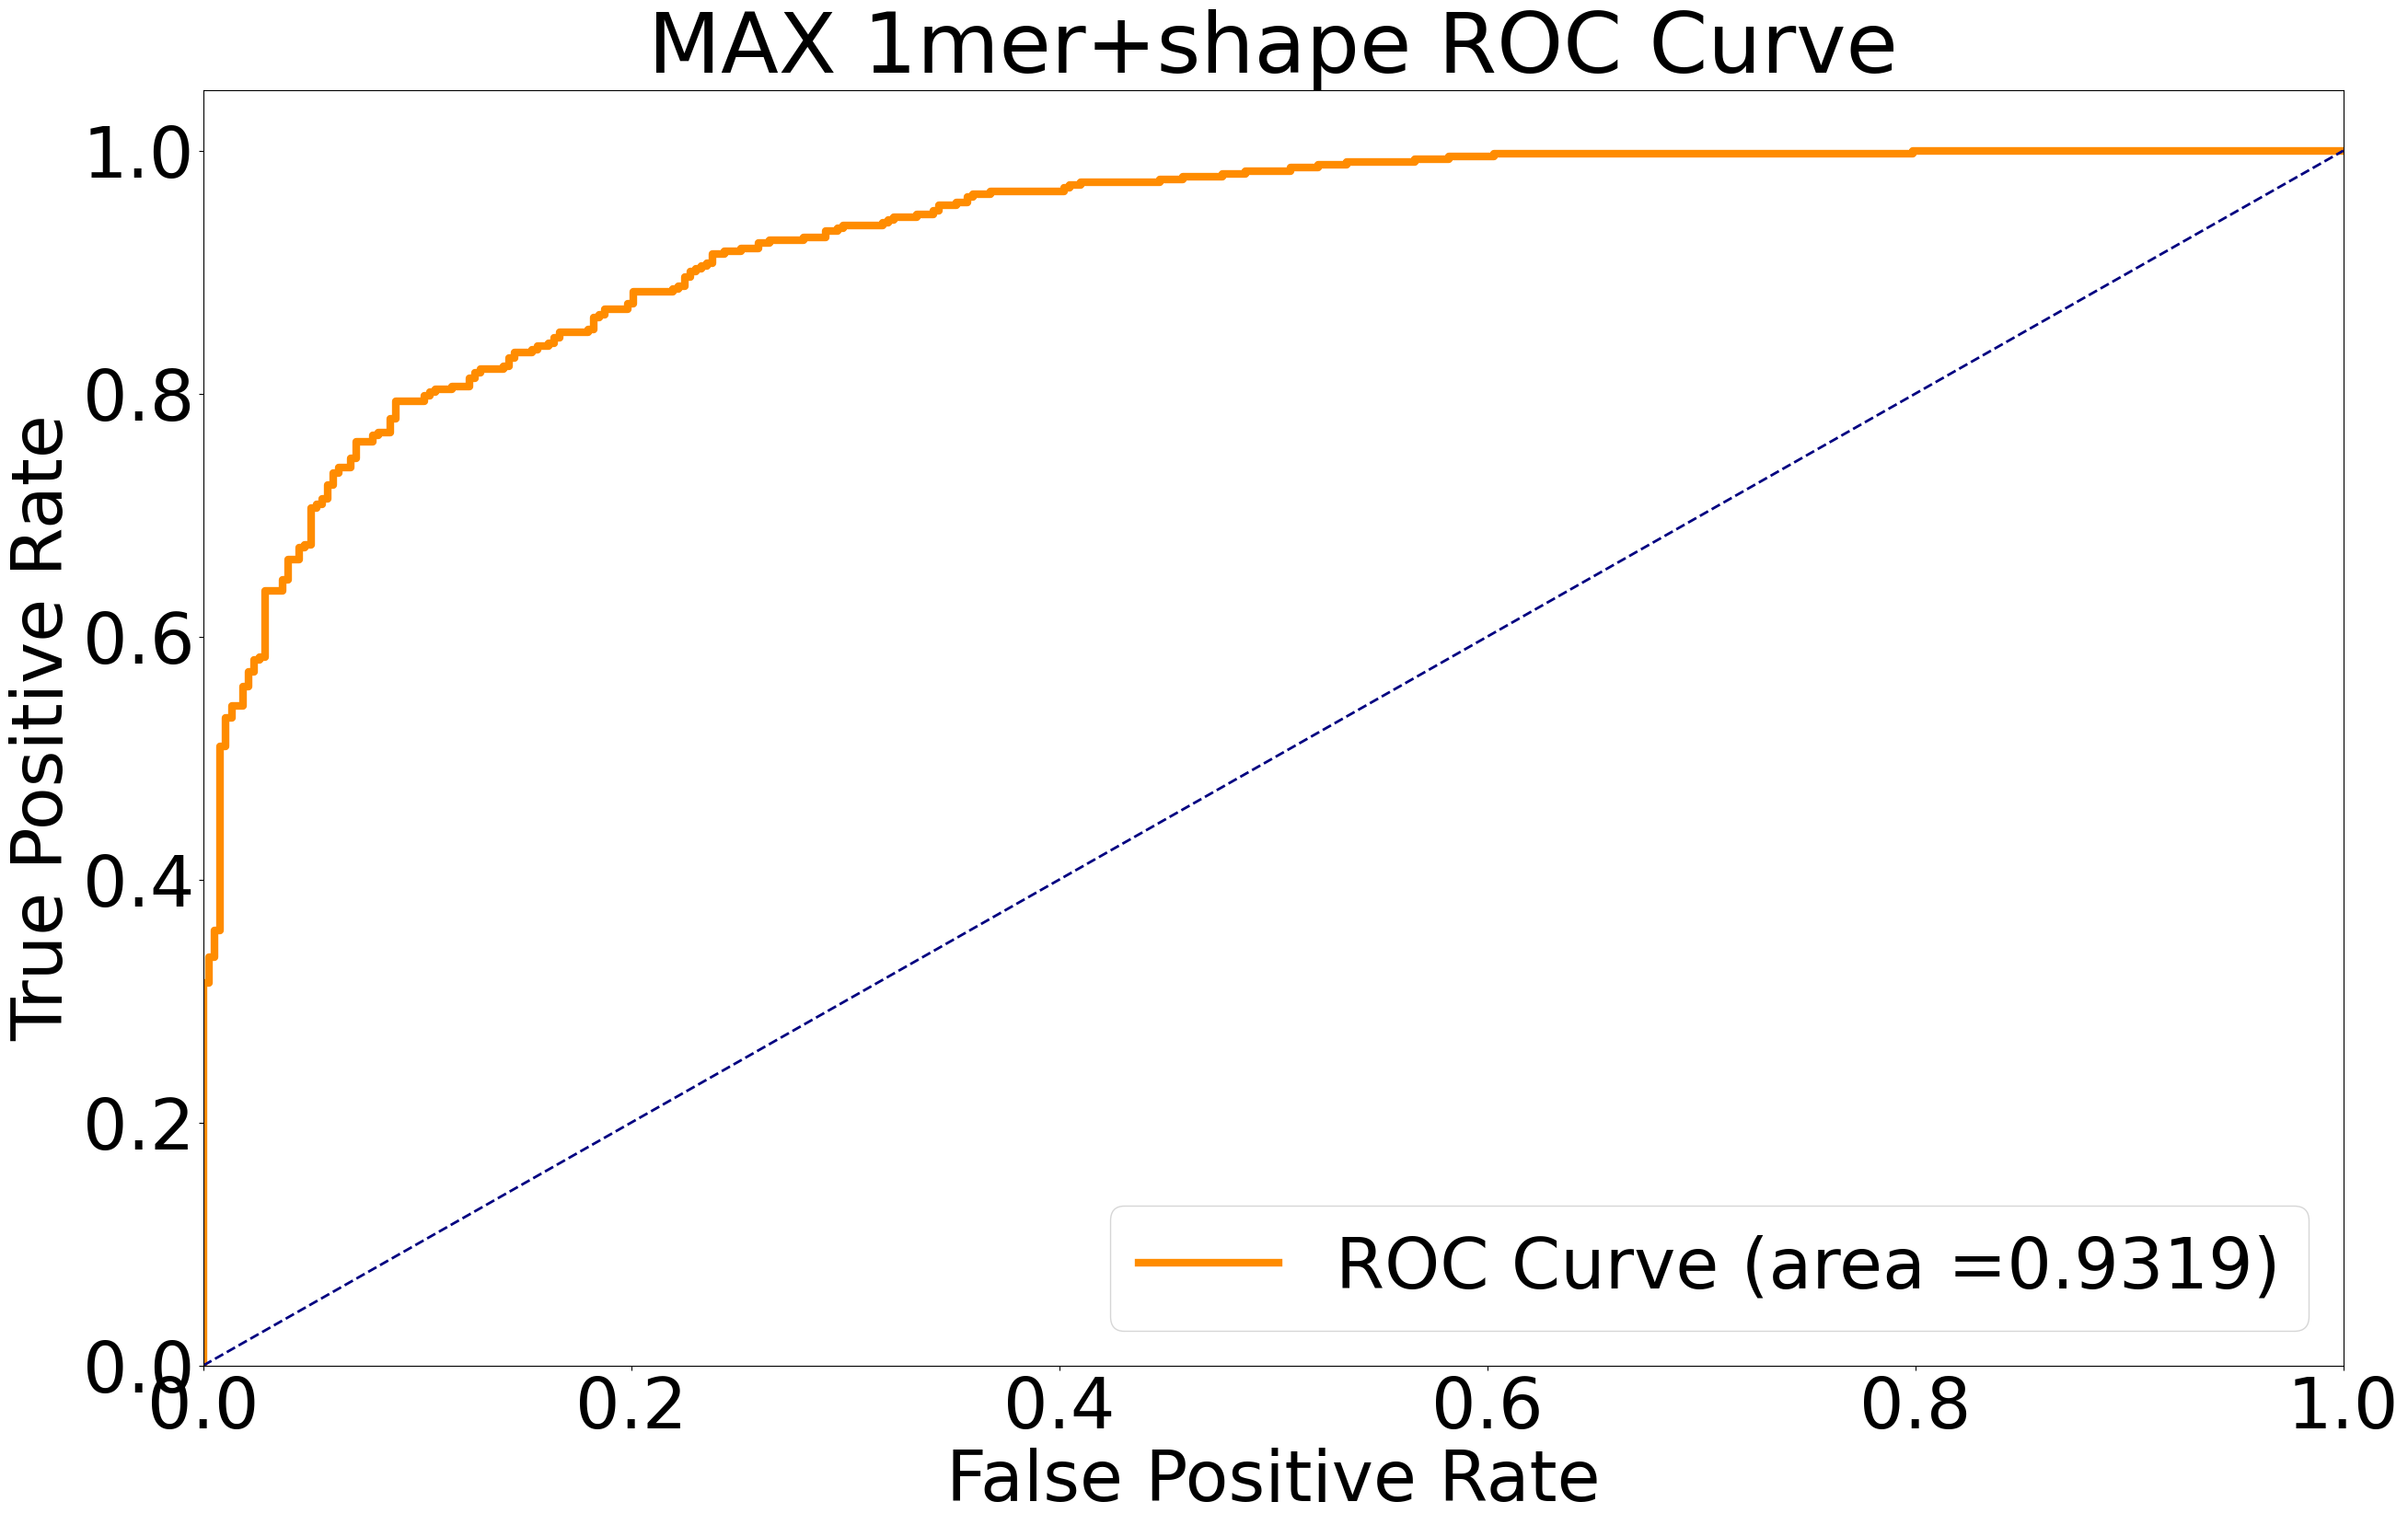

In [12]:
evaluate_model(X_max_1mer_shape_train, X_max_1mer_shape_test, y_max_1mer_shape_train, y_max_1mer_shape_test, 0.1, 'MAX 1mer+shape')

We can see from these plots that all four models are performing pretty well. The AUROC scores show that in general the models trained for the CTCF transcription factor perform slightly better than the models for the MAX transcription factor. Also, we can see that adding in the shape features barely improves performance, thus the benefits of implementing the shape features are not as significant as with linear regression from the previous assignment. 